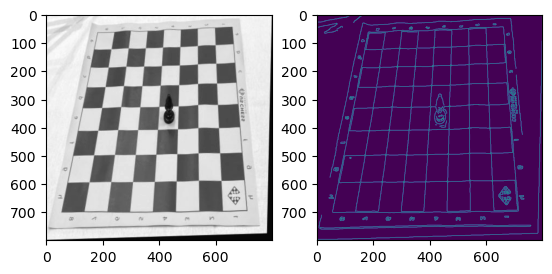

In [8]:
from src.utils import * # also import numpy and cv
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import canny
from skimage.transform import hough_line,hough_line_peaks
import math
import copy
from scipy.spatial.distance import cdist

from src.chessboard import *

from sklearn.linear_model import RANSACRegressor

files = [os.path.join(os.getcwd(),'data_new',f) for f in os.listdir('./data_new/')]
img = load_skimage(files[234])
edges = canny(img)

fig,axs=plt.subplots(1,2)
axs[0].imshow(img,cmap='gray')
axs[1].imshow(edges)

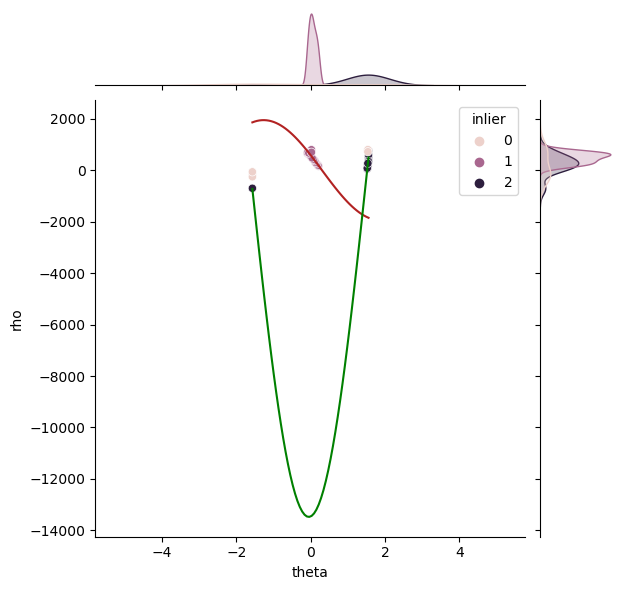

In [9]:
ransac_kwargs = {
    'min_samples' : 4,
    'max_trials' : 100000
}


vp_1,vp_2,peaks,hspace,angles,distances=bootstrap_sinusoidal(edges,num_peaks=30,ransac_kwargs=ransac_kwargs)

theta = np.linspace(peaks.theta.min(),peaks.theta.max())
rho_pred_1 = vp_1[0]*np.cos(theta) + vp_1[1]*np.sin(theta)
rho_pred_2 = vp_2[0]*np.cos(theta) + vp_2[1]*np.sin(theta)


_=sns.jointplot(data=peaks,x='theta',y='rho',hue='inlier')
_.ax_joint.plot(theta,rho_pred_1,color='firebrick')
_.ax_joint.plot(theta,rho_pred_2,color='green')



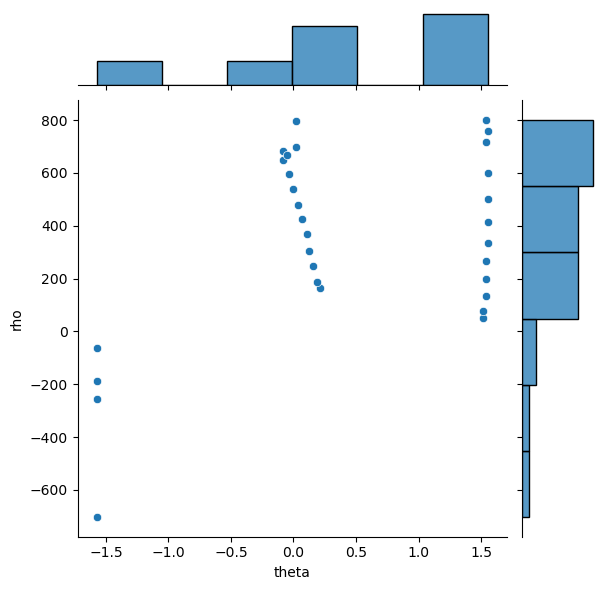

In [10]:
_=sns.jointplot(data=peaks,x='theta',y='rho')

C:\Users\demle\AppData\Local\Temp\ipykernel_13300\128456850.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  a = -np.cos(phi)/np.sin(phi)
C:\Users\demle\AppData\Local\Temp\ipykernel_13300\128456850.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  b = rho/np.sin(phi)
C:\Users\demle\AppData\Local\Temp\ipykernel_13300\128456850.py:13: RuntimeWarning: invalid value encountered in multiply
  axs[0].plot(x,a*x + b,color='red',linestyle='--')
C:\Users\demle\AppData\Local\Temp\ipykernel_13300\128456850.py:13: RuntimeWarning: invalid value encountered in add
  axs[0].plot(x,a*x + b,color='red',linestyle='--')


Text(0.5, 1.0, 'Test lines')

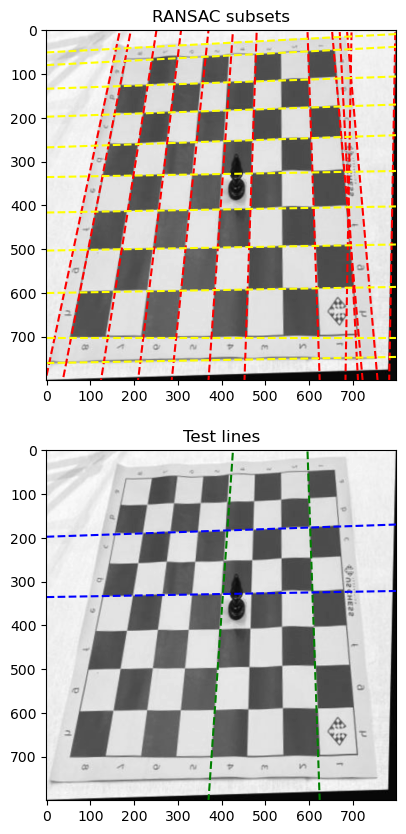

In [11]:
fig,axs = plt.subplots(2,1,figsize=[15,10])


x = np.arange(img.shape[1])




for l in peaks[peaks.inlier==1][['rho','theta']].iterrows():
    rho,phi = l[1]
    a = -np.cos(phi)/np.sin(phi)
    b = rho/np.sin(phi)
    axs[0].plot(x,a*x + b,color='red',linestyle='--')

for l in peaks[peaks.inlier==2][['rho','theta']].iterrows():
    rho,phi = l[1]
    a = -np.cos(phi)/np.sin(phi)
    b = rho/np.sin(phi)
    axs[0].plot(x,a*x + b,color='yellow',linestyle='--')


axs[0].imshow(img,cmap='gray')

# grab the i-th row closest to the specified field median
def get_median_row(dataframe,column,distance=0):
    median = dataframe.median()[column]
    arg = abs(dataframe[column]-median).sort_values().index[distance]
    return dataframe.loc[arg]
    

# grab a couple lines
# two lines from one group
q1 = 0.4
q2 = 0.6

la1 = peaks[peaks.inlier==1][peaks[peaks.inlier==1].rho == peaks[peaks.inlier==1].rho.quantile(q1,interpolation='lower')][['rho','theta']].values[0]
lb1 = peaks[peaks.inlier==1][peaks[peaks.inlier==1].rho == peaks[peaks.inlier==1].rho.quantile(q2,interpolation='higher')][['rho','theta']].values[0]

la2 = peaks[peaks.inlier==2][peaks[peaks.inlier==2].rho == peaks[peaks.inlier==2].rho.quantile(q1,interpolation='lower')][['rho','theta']].values[0]
lb2 = peaks[peaks.inlier==2][peaks[peaks.inlier==2].rho == peaks[peaks.inlier==2].rho.quantile(q2,interpolation='lower')][['rho','theta']].values[0]

for line in [la1,lb1]:
    rho,phi = line
    a = -np.cos(phi)/np.sin(phi)
    b = rho/np.sin(phi)
    axs[1].plot(x,a*x + b,color='green',linestyle='--')

for line in [la2,lb2]:
    rho,phi = line
    a = -np.cos(phi)/np.sin(phi)
    b = rho/np.sin(phi)
    axs[1].plot(x,a*x + b,color='blue',linestyle='--')

axs[1].imshow(img,cmap='gray')

axs[0].set_title('RANSAC subsets')
axs[1].set_title('Test lines')

Text(0.5, 1.0, 'Final fitted chessboard')

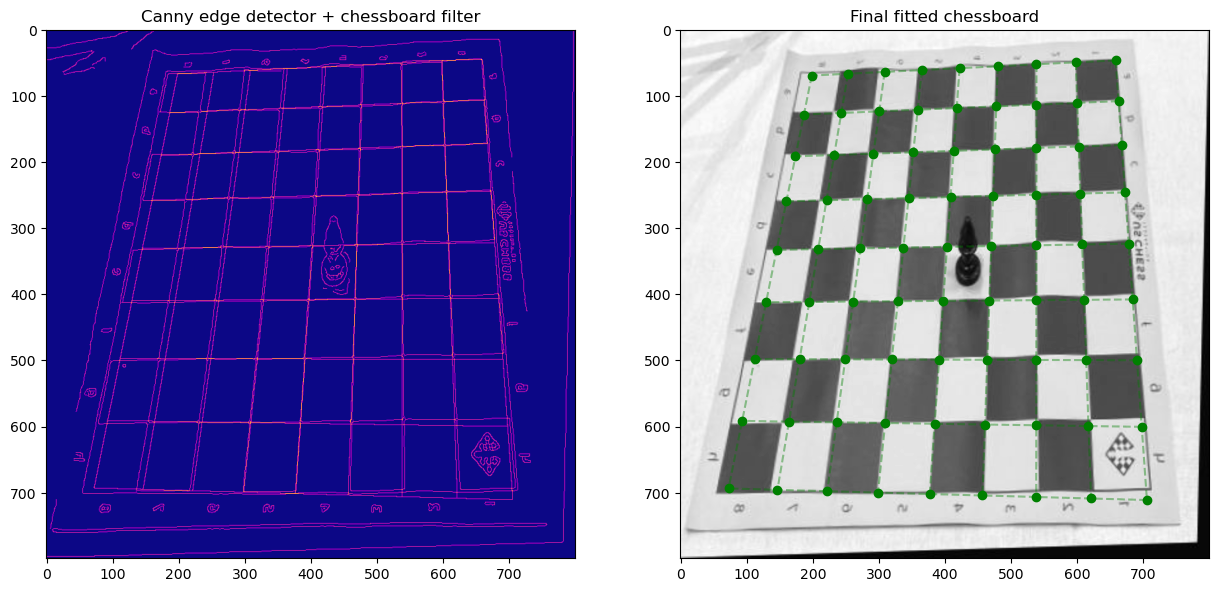

In [20]:
# now, for the selected lines, we try every possible combinations of indices and see the best one

fig,axs = plt.subplots(1,2,figsize=[15,10])
x = np.arange(img.shape[1])

chessboard = Chessboard()

# for line in [line_1,line_2,line_3,line_4]:
#     rho,phi = line
#     a = -np.cos(phi)/np.sin(phi)
#     b = rho/np.sin(phi)
#     ax.plot(x,a*x + b,color='yellow',linestyle='--')


def chessboard_loss_closest(chessboard,peaks):

    # compute distances
    dists = cdist(chessboard.warped_lines_,peaks[['rho','theta']].values,metric='minkowski',p=1.)
    # get minimum for each of the chessboardlines
    min_dists = np.min(dists,axis=1)
    n_unique_matches=len(np.unique(np.argmin(dists,axis=1)))
    gamma=10.

    return (min_dists.sum() + gamma*(18-n_unique_matches)),n_unique_matches

def chessboard_loss_transform(chessboard,hspace,angles,distances):
    
    loss = 0

    for line in chessboard.warped_lines_:
        rho,theta=line
        itheta=np.argmin(abs(angles-theta))
        irho=np.argmin(abs(distances-rho))
        loss += hspace[irho,itheta]
    return -loss
    

def test_lines(la1,lb1,la2,lb2,edges):

    chessboard = Chessboard()
    best_loss = np.inf

    for i in range(0,7):
        for j in range(i+1,8):
            for k in range(0,7):
                for l in range(k+1,8):

                    chessboard.warp_from_lines(np.array([la1,lb1,la2,lb2]),(i,j,k,l))
                    # loss = chessboard_loss_transform(chessboard,hspace,angles,distances)
                    loss = -(chessboard.draw_filter(*edges.shape,thickness=3)*edges).sum()
                    
                    
                    
                    
                    if loss < best_loss:
                        best_loss = loss
                        best_chessboard = copy.deepcopy(chessboard)
    
    return best_chessboard,best_loss




axs[1].imshow(img,cmap='gray')
best_chessboard,best_loss = test_lines(la1,lb1,la2,lb2,edges)
best_chessboard.plot_chessboard(axs[1])
axs[0].imshow(edges+best_chessboard.draw_filter(*img.shape),cmap='plasma')

axs[0].set_title('Canny edge detector + chessboard filter')
axs[1].set_title('Final fitted chessboard')

In [80]:
peaks[peaks.inlier==1].rho.quantile(0.4,interpolation='lower')

425.0

In [81]:
peaks[peaks.inlier==1][peaks[peaks.inlier==1].rho == peaks[peaks.inlier==1].rho.quantile(0.4,interpolation='lower')][['rho','theta']].values[0]

array([4.25000000e+02, 6.98131701e-02])

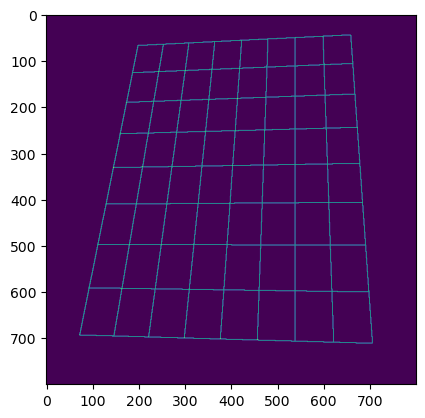

In [15]:
plt.imshow(best_chessboard.draw_filter(*img.shape))